In [23]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc,classification_report,accuracy_score

import matplotlib.pyplot as plt
from itertools import chain
#from sklearn.metrics import , roc_curve, auc
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.io import read_image
from torchvision.datasets.folder import default_loader
from tqdm import tqdm

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
#cd "D:\Depaul\DATA_SCIENCE\prog_ml_apps\DATASET\archive (5)"

In [3]:
import os
os.chdir("/home/syavari/repo/Image-Classification/downloads")

In [4]:
# Load data
data = pd.read_csv('Data_Entry_2017.csv')
my_glob = glob('images*/images/*.png')
all_image_paths = {os.path.basename(x): x for x in my_glob}


In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(all_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x[:-1]) if isinstance(x, str) else x)
data.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94965,00024685_000.png,No Finding,0,24685,39,F,PA,2650,2665,0.143,0.143,NaN,images_010/images/00024685_000.png
57484,00014253_026.png,Atelectasis|Effusion,26,14253,60,M,AP,2500,2048,0.168,0.168,NaN,images_007/images/00014253_026.png
40411,00010530_006.png,No Finding,6,10530,36,F,PA,2510,2597,0.143,0.143,NaN,images_005/images/00010530_006.png


In [6]:
# Process labels
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', '') if pd.notnull(x) else '')
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1:
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
62876,00015551_000.png,,0,15551,53,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59163,00014635_003.png,Effusion|Infiltration|Nodule,3,14635,67,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
33107,00008687_004.png,,4,8687,43,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Filter labels
MIN_CASES = 1000
all_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']
print('Clean Labels ({})'.format(len(all_labels)), [(c_label, int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (6) [('Effusion', 13317), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Atelectasis', 11559), ('Pneumothorax', 5302)]


In [8]:
# Dropping unnecessary columns
columns_to_drop = ['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 
                   'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
data = data.drop(columns=[col for col in columns_to_drop if col in data])

In [9]:
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

counts = data['Finding Labels'].value_counts()
mask = data['Finding Labels'].isin(counts[counts >= 251].index)
data = data[mask]

In [10]:
# Filter patients with exactly one disease
data['Total Diseases'] = data[all_labels].sum(axis=1)
data_one_disease = data[data['Total Diseases'] == 1]

In [11]:
data_one_disease.head()

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec,Total Diseases
2,00000001_002.png,Cardiomegaly|Effusion,images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0
19,00000005_006.png,Infiltration,images_001/images/00000005_006.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
25,00000008_002.png,Nodule,images_001/images/00000008_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",1.0
27,00000010_000.png,Infiltration,images_001/images/00000010_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
28,00000011_000.png,Effusion,images_001/images/00000011_000.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0


In [12]:
train_df, valid_df = train_test_split(data_one_disease, test_size=0.2, random_state=123)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 21916 validation 5479


In [13]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5479 entries, 93035 to 30566
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image Index         5479 non-null   object 
 1   Finding Labels      5479 non-null   object 
 2   path                5479 non-null   object 
 3   Atelectasis         5479 non-null   float64
 4   Cardiomegaly        5479 non-null   float64
 5   Consolidation       5479 non-null   float64
 6   Edema               5479 non-null   float64
 7   Effusion            5479 non-null   float64
 8   Emphysema           5479 non-null   float64
 9   Fibrosis            5479 non-null   float64
 10  Hernia              5479 non-null   float64
 11  Infiltration        5479 non-null   float64
 12  Mass                5479 non-null   float64
 13  Nodule              5479 non-null   float64
 14  Pleural_Thickening  5479 non-null   float64
 15  Pneumonia           5479 non-null   float64
 16  Pneumo

In [14]:
# Image transformations
IMG_SIZE = (128, 128)
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [15]:
from torch.utils.data import Dataset
 
class MedicalImageDataset(Dataset):
    def __init__(self, dataframe, labels, transform=None):
        self.dataframe = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']  # Use iloc to access the path column
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.loc[self.dataframe.index[idx], self.labels].values.astype(np.float32)  # Use loc to access label columns

        if self.transform:
            image = self.transform(image)
        
        return image, labels


In [18]:
train_dataset = MedicalImageDataset(train_df, labels=all_labels, transform=train_transforms)
valid_dataset = MedicalImageDataset(valid_df,  labels=all_labels,transform=valid_transforms)

In [19]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=4) ## change batch size 32,256
valid_loader = DataLoader(valid_dataset, batch_size=32,shuffle=False, num_workers=4)

In [20]:
# Define model
# Define model
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        self.base_model.classifier = nn.Identity()  # Remove the original classifier
        self.dense_block = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
        )
        self.transition_block = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, padding='same'),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.classifier = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.dense_block(x)
        x = self.transition_block(x)
        x = self.classifier(x)
        return x

In [22]:
# Define the model, loss, and optimizer
# model = CustomDenseNet121(num_classes=len(all_labels)).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.003)

/home/sshaik/anaconda3/envs/xray/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sshaik/anaconda3/envs/xray/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model = CustomDenseNet121(num_classes=len(all_labels)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

/home/sshaik/anaconda3/envs/xray/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sshaik/anaconda3/envs/xray/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:

def verify_dataloader(dataloader, num_batches=1):
    for i, (images, labels) in enumerate(dataloader):
        print(f"Batch {i+1}:")
        print(f"Image batch shape: {images.shape}")
        print(f"Label batch shape: {labels.shape}")
        print(f"Labels: {labels}")
        if i+1 >= num_batches:
            break

# Verify the validation DataLoader
verify_dataloader(valid_loader, num_batches=3)

Batch 1:
Image batch shape: torch.Size([32, 3, 128, 128])
Label batch shape: torch.Size([32, 6])
Labels: tensor([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1.

In [25]:


# Ensure the directory exists for saving the model
save_dir = '/home/sshaik/xray'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'best_model.pth')

# Training loop with early stopping and learning rate scheduler
num_epochs = 50
best_loss = float('inf')
early_stopping_patience = 3
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(valid_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), model_path)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping")
        break

# Load the best model
model.load_state_dict(torch.load(model_path))


100%|██████████| 685/685 [01:27<00:00,  7.87it/s]


Epoch 1/50, Train Loss: 0.4076, Val Loss: 0.4074


100%|██████████| 685/685 [01:24<00:00,  8.10it/s]


Epoch 2/50, Train Loss: 0.3967, Val Loss: 0.4094


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 3/50, Train Loss: 0.3897, Val Loss: 0.3913


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 4/50, Train Loss: 0.3838, Val Loss: 0.4042


100%|██████████| 685/685 [01:25<00:00,  8.00it/s]


Epoch 5/50, Train Loss: 0.3785, Val Loss: 0.3880


100%|██████████| 685/685 [01:24<00:00,  8.07it/s]


Epoch 6/50, Train Loss: 0.3732, Val Loss: 0.3824


100%|██████████| 685/685 [01:24<00:00,  8.09it/s]


Epoch 7/50, Train Loss: 0.3690, Val Loss: 0.3882


100%|██████████| 685/685 [01:24<00:00,  8.07it/s]


Epoch 8/50, Train Loss: 0.3653, Val Loss: 0.3779


100%|██████████| 685/685 [01:28<00:00,  7.73it/s]


Epoch 9/50, Train Loss: 0.3622, Val Loss: 0.3653


100%|██████████| 685/685 [01:29<00:00,  7.61it/s]


Epoch 10/50, Train Loss: 0.3582, Val Loss: 0.3771


100%|██████████| 685/685 [01:24<00:00,  8.10it/s]


Epoch 11/50, Train Loss: 0.3551, Val Loss: 0.3673


100%|██████████| 685/685 [01:25<00:00,  7.97it/s]


Epoch 12/50, Train Loss: 0.3515, Val Loss: 0.3769
Early stopping


<All keys matched successfully>

In [23]:
# # Ensure the directory exists for saving the model
# save_dir = '/home/sshaik/xray'
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, 'best_model.pth')

# # Training loop
# num_epochs = 50
# best_loss = float('inf')
# early_stopping_patience = 3
# early_stopping_counter = 0

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for images, labels in tqdm(train_loader):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * images.size(0)
    
#     train_loss /= len(train_loader.dataset)

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, labels in valid_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * images.size(0)
    
#     val_loss /= len(valid_loader.dataset)

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

#     if val_loss < best_loss:
#         best_loss = val_loss
#         torch.save(model.state_dict(), model_path)
#         early_stopping_counter = 0
#     else:
#         early_stopping_counter += 1
    
#     if early_stopping_counter >= early_stopping_patience:
#         print("Early stopping")
#         break

# # Load the best model
# model.load_state_dict(torch.load(model_path))

100%|██████████| 685/685 [01:26<00:00,  7.92it/s]


Epoch 1/50, Train Loss: 1.5737, Val Loss: 1.7106


100%|██████████| 685/685 [01:23<00:00,  8.16it/s]


Epoch 2/50, Train Loss: 1.5184, Val Loss: 1.6254


100%|██████████| 685/685 [01:24<00:00,  8.09it/s]


Epoch 3/50, Train Loss: 1.4806, Val Loss: 1.5025


100%|██████████| 685/685 [01:24<00:00,  8.13it/s]


Epoch 4/50, Train Loss: 1.4549, Val Loss: 1.4679


100%|██████████| 685/685 [01:24<00:00,  8.11it/s]


Epoch 5/50, Train Loss: 1.4277, Val Loss: 1.5033


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 6/50, Train Loss: 1.4099, Val Loss: 1.4371


100%|██████████| 685/685 [01:25<00:00,  8.03it/s]


Epoch 7/50, Train Loss: 1.3878, Val Loss: 1.4192


100%|██████████| 685/685 [01:24<00:00,  8.06it/s]


Epoch 8/50, Train Loss: 1.3697, Val Loss: 1.4056


100%|██████████| 685/685 [01:25<00:00,  8.04it/s]


Epoch 9/50, Train Loss: 1.3505, Val Loss: 1.4099


100%|██████████| 685/685 [01:24<00:00,  8.10it/s]


Epoch 10/50, Train Loss: 1.3368, Val Loss: 1.3960


100%|██████████| 685/685 [01:26<00:00,  7.89it/s]


Epoch 11/50, Train Loss: 1.3217, Val Loss: 1.3877


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 12/50, Train Loss: 1.3045, Val Loss: 1.3667


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 13/50, Train Loss: 1.2852, Val Loss: 1.3693


100%|██████████| 685/685 [01:26<00:00,  7.94it/s]


Epoch 14/50, Train Loss: 1.2656, Val Loss: 1.3749


100%|██████████| 685/685 [01:26<00:00,  7.92it/s]


Epoch 15/50, Train Loss: 1.2486, Val Loss: 1.3595


100%|██████████| 685/685 [01:25<00:00,  8.06it/s]


Epoch 16/50, Train Loss: 1.2308, Val Loss: 1.4081


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 17/50, Train Loss: 1.2152, Val Loss: 1.3610


100%|██████████| 685/685 [01:24<00:00,  8.06it/s]


Epoch 18/50, Train Loss: 1.1933, Val Loss: 1.3570


100%|██████████| 685/685 [01:25<00:00,  8.02it/s]


Epoch 19/50, Train Loss: 1.1659, Val Loss: 1.4075


100%|██████████| 685/685 [01:25<00:00,  8.04it/s]


Epoch 20/50, Train Loss: 1.1437, Val Loss: 1.3708


100%|██████████| 685/685 [01:25<00:00,  8.03it/s]


Epoch 21/50, Train Loss: 1.1166, Val Loss: 1.3646


100%|██████████| 685/685 [01:25<00:00,  8.05it/s]


Epoch 22/50, Train Loss: 1.0890, Val Loss: 1.3966


100%|██████████| 685/685 [01:25<00:00,  8.04it/s]


Epoch 23/50, Train Loss: 1.0498, Val Loss: 1.4008
Early stopping


<All keys matched successfully>

In [41]:
valid_df.head()

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec,Total Diseases
93035,00023231_000.png,Mass,images_010/images/00023231_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",1.0
48151,00012200_000.png,Mass,images_006/images/00012200_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",1.0
95150,00024864_000.png,Infiltration,images_011/images/00024864_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
75361,00018494_012.png,Infiltration,images_009/images/00018494_012.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
109778,00029863_024.png,Effusion,images_012/images/00029863_024.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0


Shape of all_labels_list: (5479, 6)
Shape of all_preds: (5479, 6)
Shape of all_probs: (5479, 6)
Unique values in all_labels_list: [0. 1.]
Unique values in all_preds: [False  True]
              precision    recall  f1-score   support

    Effusion       0.64      0.31      0.42       973
Infiltration       0.60      0.52      0.56      2033
        Mass       0.00      0.00      0.00       450
      Nodule       0.00      0.00      0.00       565
 Atelectasis       0.58      0.12      0.20       961
Pneumothorax       0.61      0.03      0.06       497

   micro avg       0.61      0.27      0.37      5479
   macro avg       0.40      0.16      0.21      5479
weighted avg       0.49      0.27      0.32      5479
 samples avg       0.27      0.27      0.27      5479

Accuracy: 0.2714
F1 Score (Micro): 0.3748
F1 Score (Macro): 0.2064


/home/sshaik/anaconda3/envs/xray/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshaik/anaconda3/envs/xray/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


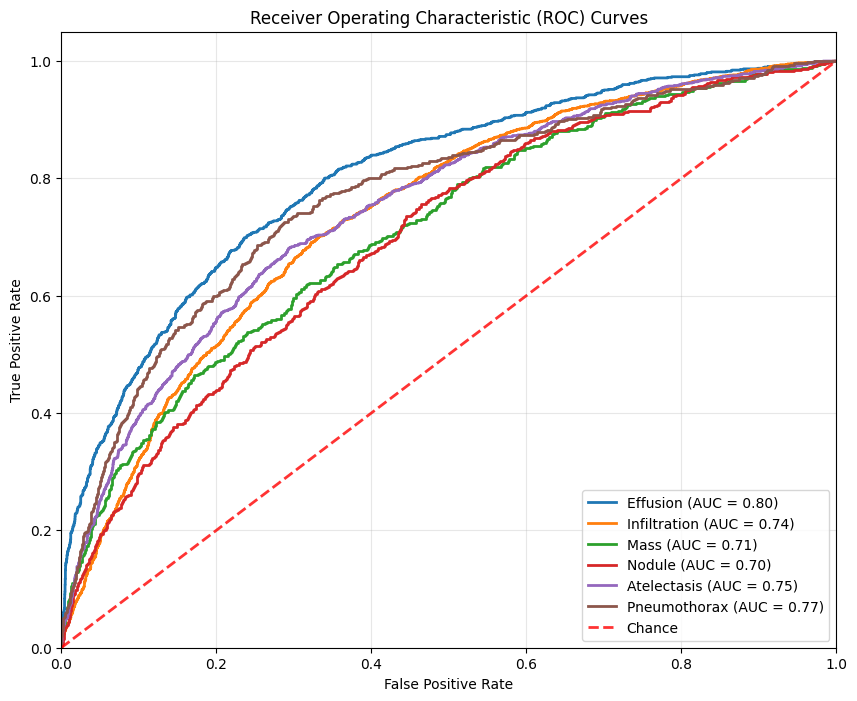

In [27]:
# Evaluation
model.eval()
all_preds = []
all_labels_list = []
all_probs = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = probs > 0.5
        
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels_list.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels_list = np.concatenate(all_labels_list)

# Verify shapes and types
print("Shape of all_labels_list:", all_labels_list.shape)
print("Shape of all_preds:", all_preds.shape)
print("Shape of all_probs:", all_probs.shape)
print("Unique values in all_labels_list:", np.unique(all_labels_list))
print("Unique values in all_preds:", np.unique(all_preds))

# Print classification report
report = classification_report(all_labels_list, all_preds, target_names=all_labels)
print(report)

# Calculate and print overall accuracy
accuracy = accuracy_score(all_labels_list, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print overall F1 score (micro and macro)
f1_micro = f1_score(all_labels_list, all_preds, average='micro')
f1_macro = f1_score(all_labels_list, all_preds, average='macro')
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")

# Calculate ROC and AUC for each label
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, label in enumerate(all_labels):
    fpr[label], tpr[label], _ = roc_curve(all_labels_list[:, i], all_probs[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for label in all_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label=f'{label} (AUC = {roc_auc[label]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [34]:
def check_class_distribution(dataframe, labels):
    for label in labels:
        positive_samples = dataframe[label].sum()
        print(f"{label}: {positive_samples} positive samples")

# Assuming train_df is your training DataFrame
check_class_distribution(train_df, all_labels)



Effusion: 4054.0 positive samples
Infiltration: 8347.0 positive samples
Mass: 1689.0 positive samples
Nodule: 2140.0 positive samples
Atelectasis: 3652.0 positive samples
Pneumothorax: 2034.0 positive samples
